In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xgboost as xgb

%matplotlib inline

In [2]:
df = pd.read_csv('./data/data.csv')

In [3]:
df=df.rename(columns = {"Unnamed: 0": "Date"})

In [4]:
df.tail()

,Date,Load,CAPITL,CENTRL,DUNWOD,GENESE,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,WEST,N.Y.C._LONGIL
145915,2017-04-24 19:00:00,16984.175000,1291.972222,1768.647222,654.152778,1058.680556,1062.383333,2238.380556,855.547222,289.441667,5559.388889,487.286111,1718.294444,NaN
145916,2017-04-24 20:00:00,17615.657540,1341.735714,1843.365873,683.256349,1108.247222,1122.049603,2388.324206,884.457540,311.366270,5647.025397,498.217460,1787.611905,NaN
145917,2017-04-24 21:00:00,17200.752778,1290.469444,1801.922222,675.925000,1091.652778,1086.563889,2318.411111,846.966667,290.966667,5521.511111,492.600000,1783.763889,NaN
145918,2017-04-24 22:00:00,16148.388889,1193.955556,1687.572222,641.322222,1011.200000,1007.902778,2140.886111,776.563889,258.008333,5256.850000,475.905556,1698.222222,NaN
145919,2017-04-24 23:00:00,14931.883333,1092.930556,1577.530556,583.055556,933.863889,920.994444,1937.283333,699.247222,231.258333,4895.633333,460.969444,1599.116667,NaN


In [5]:
df.Date = pd.to_datetime(df.Date)

In [6]:
df.set_index('Date', inplace = True)

In [7]:
df.sort_index(inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145920 entries, 2003-01-01 00:00:00 to 2019-07-31 23:00:00
Data columns (total 13 columns):
Load             145290 non-null float64
CAPITL           145290 non-null float64
CENTRL           145290 non-null float64
DUNWOD           145290 non-null float64
GENESE           145290 non-null float64
HUD VL           145290 non-null float64
LONGIL           127065 non-null float64
MHK VL           145290 non-null float64
MILLWD           145290 non-null float64
N.Y.C.           127065 non-null float64
NORTH            145290 non-null float64
WEST             145290 non-null float64
N.Y.C._LONGIL    18225 non-null float64
dtypes: float64(13)
memory usage: 15.6 MB


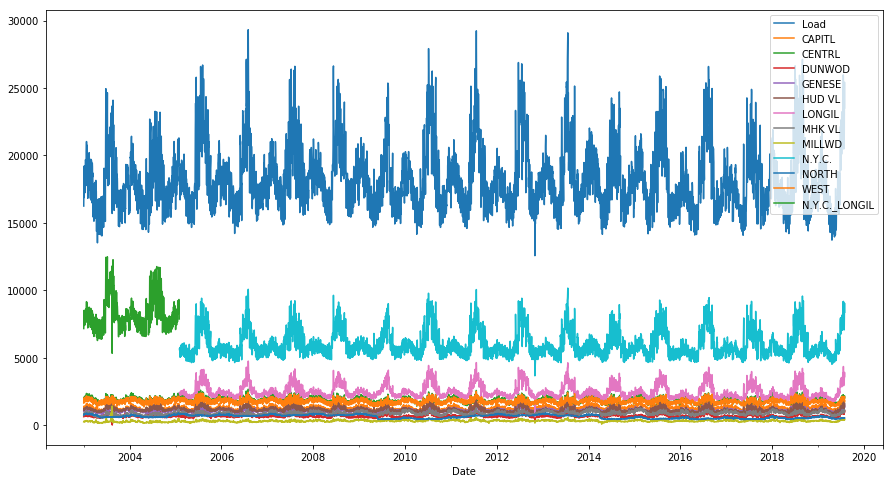

In [9]:
days = df.resample("D")
days_=days.mean()
days_.plot(kind = 'line', figsize=(15, 8))
plt.show()

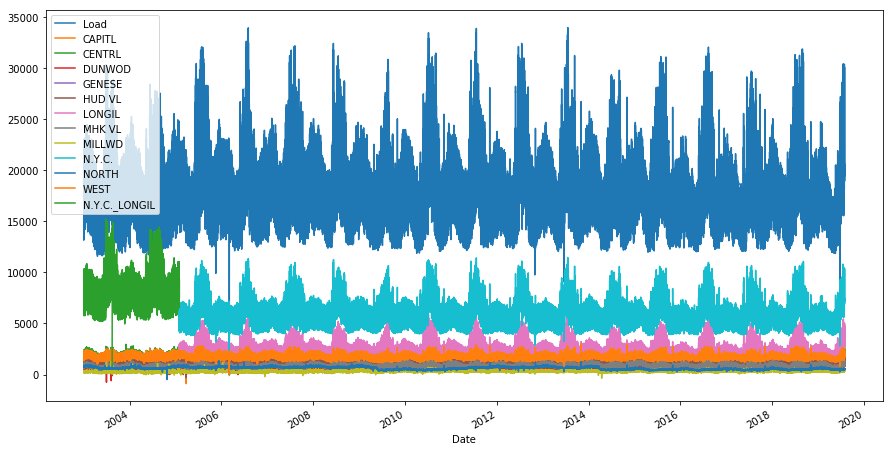

In [10]:
df.plot(kind = 'line', figsize=(15, 8))
plt.show()

In [11]:
df.tail()

,Load,CAPITL,CENTRL,DUNWOD,GENESE,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,WEST,N.Y.C._LONGIL
Date,,,,,,,,,,,,,
2019-07-31 19:00:00,24835.000000,1947.066667,2294.158333,964.691667,1518.908333,1498.525000,3807.300000,1143.666667,430.083333,8408.100000,585.041667,2237.458333,NaN
2019-07-31 20:00:00,24219.675000,1896.200000,2219.283333,948.775000,1435.250000,1473.858333,3710.075000,1124.775000,435.516667,8286.316667,550.741667,2138.883333,NaN
2019-07-31 21:00:00,23578.041667,1842.125000,2147.391667,921.316667,1390.575000,1420.908333,3560.058333,1093.925000,423.700000,8140.341667,539.916667,2097.783333,NaN
2019-07-31 22:00:00,22177.316667,1699.375000,1982.983333,867.841667,1269.191667,1321.225000,3282.200000,1007.658333,387.158333,7849.108333,518.491667,1992.083333,NaN
2019-07-31 23:00:00,20562.291667,1551.416667,1798.033333,803.283333,1161.616667,1214.883333,2986.000000,914.350000,352.566667,7434.916667,514.658333,1830.566667,NaN


In [12]:
def get_slope(y):
    x = range(len(y))
    slope = np.polyfit(x, y, 1)[0]
    return slope

In [13]:
def get_acceleration(y):
    x = range(len(y))
    acc = 0.5*np.polyfit(x, y, 2)[0]
    return acc

In [14]:
def cyc_feats(df, feat):
    start = df.index[0].date().year-1
    df['cyc_{0}_x'.format(str(feat))] = np.cos(((2*np.pi)/df[feat])*(df['year']-(start))) #x-coord
    df['cyc_{0}_y'.format(str(feat))] = np.sin(((2*np.pi)/df[feat])*(df['year']-(start))) #y-coord
    return df

In [15]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    for i in [14, 28, 60, 90, 120]:
        df['MA_{0}'.format(str(i))] = df['Load'].rolling(24*i).mean() # rolling average
        df['MMAX_{0}'.format(str(i))] = df['Load'].rolling(24*i).max() # rolling maximum
        df['MMIN_{0}'.format(str(i))] = df['Load'].rolling(24*i).min() # rolling minimum
        df['MSTD_{0}'.format(str(i))] = df['Load'].rolling(24*i).std() # rolling standard deviation
        df['MSLOPE_{0}'.format(str(i))] = df['Load'].rolling(24*i).apply(lambda x: get_slope(x), raw=True) # rolling slope
        df['MACC_{0}'.format(str(i))] = df['Load'].rolling(24*i).apply(lambda x: get_acceleration(x),raw=True) # rolling acceleration
    for i in [1, 7, 30, 60, 90, 180, 365]:
        # add the lagged Load as a feature
        df['lag_{0}'.format(str(i))] = df['Load'].shift(24*i)
        # as well as the percentage of the current Load for each lagged closing price
        df['pct_{0}'.format(str(i))] = df['lag_{0}'.format(str(i))] / df['Load']
   
    #create cyclical features
    feats = ['month', 'dayofmonth', 'dayofyear', 'weekofyear']
    for feat in feats:
        df = cyc_feats(df, feat)
    keep_cols =[col for col in df.columns.tolist() if col not in ['Load', 'date']]
#     keep_cols.remove('Load')
#     keep_cols.remove('date')


    X = df[keep_cols].fillna(0)
    if label:
        y = df[label]
        return X, y
    return X

In [16]:
def split_data(data, start_date, split_date):
        return data[(start_date) : (split_date)].copy(), \
               data[data.index >  split_date].copy()

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145920 entries, 2003-01-01 00:00:00 to 2019-07-31 23:00:00
Data columns (total 13 columns):
Load             145290 non-null float64
CAPITL           145290 non-null float64
CENTRL           145290 non-null float64
DUNWOD           145290 non-null float64
GENESE           145290 non-null float64
HUD VL           145290 non-null float64
LONGIL           127065 non-null float64
MHK VL           145290 non-null float64
MILLWD           145290 non-null float64
N.Y.C.           127065 non-null float64
NORTH            145290 non-null float64
WEST             145290 non-null float64
N.Y.C._LONGIL    18225 non-null float64
dtypes: float64(13)
memory usage: 20.6 MB


In [18]:
df.isna().sum()

Load                630
CAPITL              630
CENTRL              630
DUNWOD              630
GENESE              630
HUD VL              630
LONGIL            18855
MHK VL              630
MILLWD              630
N.Y.C.            18855
NORTH               630
WEST                630
N.Y.C._LONGIL    127695
dtype: int64

In [19]:
#drop NaNs
df.dropna(subset = ['Load'], inplace=True)
df.isna().sum()

Load                  0
CAPITL                0
CENTRL                0
DUNWOD                0
GENESE                0
HUD VL                0
LONGIL            18225
MHK VL                0
MILLWD                0
N.Y.C.            18225
NORTH                 0
WEST                  0
N.Y.C._LONGIL    127065
dtype: int64

In [20]:
df.shape

(145290, 13)

In [21]:
drop_cols = [col for col in df.columns.tolist() if col not in ['Load']]

In [22]:
# drop_cols.remove('Load')

In [23]:
df.drop(drop_cols, axis=1, inplace=True)

In [24]:
df=df.fillna(0)

In [25]:
train, test = split_data(df,'01-Jan-2018', '07-24-2019')

In [26]:
X_train, y_train = create_features(train, label='Load')

In [27]:
X_test, y_test = create_features(test, label='Load')

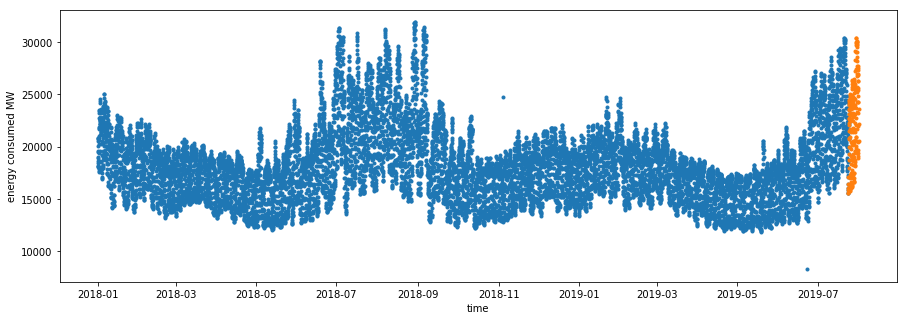

In [28]:
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('energy consumed MW')
plt.plot(X_train.index,y_train, '.')
plt.plot(X_test.index,y_test, '.')
plt.show()

In [29]:
X_train.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,MA_14,MMAX_14,...,lag_365,pct_365,cyc_month_x,cyc_month_y,cyc_dayofmonth_x,cyc_dayofmonth_y,cyc_dayofyear_x,cyc_dayofyear_y,cyc_weekofyear_x,cyc_weekofyear_y
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0,0,1,1,2018,1,1,1,0.0,0.0,...,0.0,0.0,1.0,-2.449294e-16,1.0,-2.449294e-16,1.0,-2.449294e-16,1.0,-2.449294e-16
2018-01-01 01:00:00,1,0,1,1,2018,1,1,1,0.0,0.0,...,0.0,0.0,1.0,-2.449294e-16,1.0,-2.449294e-16,1.0,-2.449294e-16,1.0,-2.449294e-16
2018-01-01 02:00:00,2,0,1,1,2018,1,1,1,0.0,0.0,...,0.0,0.0,1.0,-2.449294e-16,1.0,-2.449294e-16,1.0,-2.449294e-16,1.0,-2.449294e-16
2018-01-01 03:00:00,3,0,1,1,2018,1,1,1,0.0,0.0,...,0.0,0.0,1.0,-2.449294e-16,1.0,-2.449294e-16,1.0,-2.449294e-16,1.0,-2.449294e-16
2018-01-01 04:00:00,4,0,1,1,2018,1,1,1,0.0,0.0,...,0.0,0.0,1.0,-2.449294e-16,1.0,-2.449294e-16,1.0,-2.449294e-16,1.0,-2.449294e-16


In [30]:
X_train=X_train.fillna(0)

In [31]:
X_test=X_test.fillna(0)

In [32]:
y_test.head()

Date
2019-07-24 01:00:00    16440.950000
2019-07-24 02:00:00    15864.450000
2019-07-24 03:00:00    15539.066667
2019-07-24 04:00:00    15539.608333
2019-07-24 05:00:00    16047.483333
Name: Load, dtype: float64

In [33]:
X_train.shape, y_train.shape

((13678, 60), (13678,))

In [34]:
X_test.shape

(191, 60)

In [35]:
reg = xgb.XGBRegressor(n_estimators=1000)

In [36]:

reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        early_stopping_rounds=50, 
        verbose=False) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

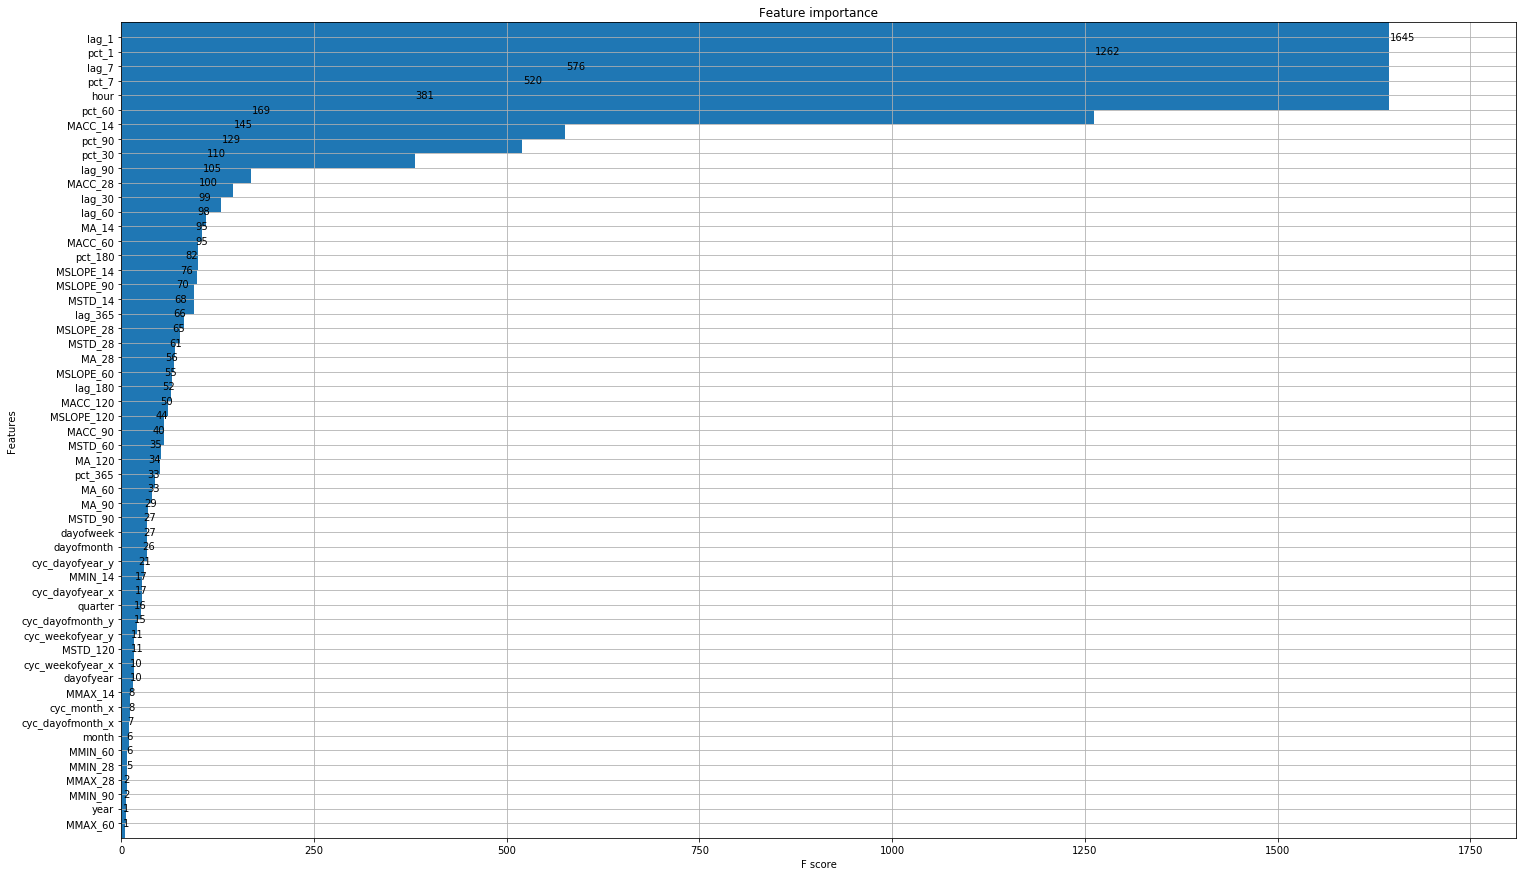

In [37]:
plt.rcParams["figure.figsize"] = (25, 15)
xgb.plot_importance(reg, height=10)


In [38]:
feats = reg.get_booster().get_score(importance_type="weight")
feats

{'lag_1': 1645,
 'pct_1': 1262,
 'lag_7': 576,
 'pct_7': 520,
 'pct_60': 169,
 'lag_60': 98,
 'hour': 381,
 'pct_30': 110,
 'pct_90': 129,
 'lag_90': 105,
 'MACC_90': 40,
 'MSTD_14': 68,
 'lag_30': 99,
 'pct_180': 82,
 'quarter': 16,
 'MA_28': 56,
 'MACC_28': 100,
 'MSLOPE_90': 70,
 'MSLOPE_120': 44,
 'MACC_14': 145,
 'MMIN_60': 6,
 'cyc_month_x': 8,
 'MA_60': 33,
 'lag_365': 66,
 'MACC_60': 95,
 'dayofweek': 27,
 'MACC_120': 50,
 'MA_120': 34,
 'MA_14': 95,
 'month': 6,
 'MA_90': 29,
 'MSTD_60': 35,
 'cyc_dayofmonth_y': 15,
 'cyc_dayofyear_x': 17,
 'MSLOPE_28': 65,
 'dayofmonth': 26,
 'MSTD_28': 61,
 'dayofyear': 10,
 'MSLOPE_60': 55,
 'MSLOPE_14': 76,
 'MMIN_14': 17,
 'MSTD_120': 11,
 'cyc_weekofyear_x': 10,
 'lag_180': 52,
 'cyc_dayofmonth_x': 7,
 'MSTD_90': 27,
 'pct_365': 33,
 'MMIN_90': 2,
 'MMIN_28': 5,
 'cyc_dayofyear_y': 21,
 'cyc_weekofyear_y': 11,
 'MMAX_14': 8,
 'MMAX_60': 1,
 'MMAX_28': 2,
 'year': 1}

In [39]:
list(feats.keys())

['lag_1',
 'pct_1',
 'lag_7',
 'pct_7',
 'pct_60',
 'lag_60',
 'hour',
 'pct_30',
 'pct_90',
 'lag_90',
 'MACC_90',
 'MSTD_14',
 'lag_30',
 'pct_180',
 'quarter',
 'MA_28',
 'MACC_28',
 'MSLOPE_90',
 'MSLOPE_120',
 'MACC_14',
 'MMIN_60',
 'cyc_month_x',
 'MA_60',
 'lag_365',
 'MACC_60',
 'dayofweek',
 'MACC_120',
 'MA_120',
 'MA_14',
 'month',
 'MA_90',
 'MSTD_60',
 'cyc_dayofmonth_y',
 'cyc_dayofyear_x',
 'MSLOPE_28',
 'dayofmonth',
 'MSTD_28',
 'dayofyear',
 'MSLOPE_60',
 'MSLOPE_14',
 'MMIN_14',
 'MSTD_120',
 'cyc_weekofyear_x',
 'lag_180',
 'cyc_dayofmonth_x',
 'MSTD_90',
 'pct_365',
 'MMIN_90',
 'MMIN_28',
 'cyc_dayofyear_y',
 'cyc_weekofyear_y',
 'MMAX_14',
 'MMAX_60',
 'MMAX_28',
 'year']

In [40]:
y_pred = reg.predict(X_test)


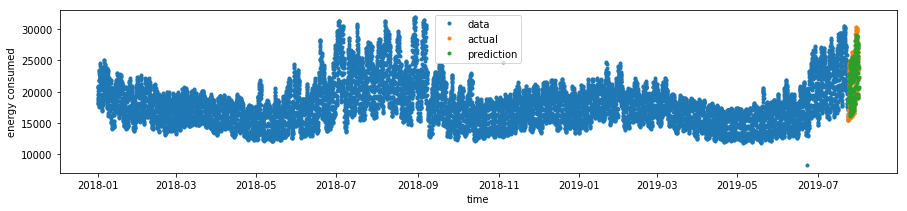

In [41]:
plt.figure(figsize=(15,3))
plt.xlabel('time')
plt.ylabel('energy consumed')
plt.plot(X_train.index, y_train, '.', label='data')
plt.plot(X_test.index, y_test, '.', label='actual')
plt.plot(X_test.index, y_pred, '.', label='prediction')
plt.legend()
# plt.xlim(left=date_from, right=date_to)
plt.show()

In [42]:
def plot_(data, target, begin, end, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(begin, end))
    else:
        plt.title(title)
    plt.xlabel('time')
    plt.ylabel('energy consumed')
    plt.plot(data.index, target, '-', label='data')
    plt.plot(X_test.index, y_pred, '.', label='prediction')
    plt.legend()
    plt.xlim(left=begin, right=end)

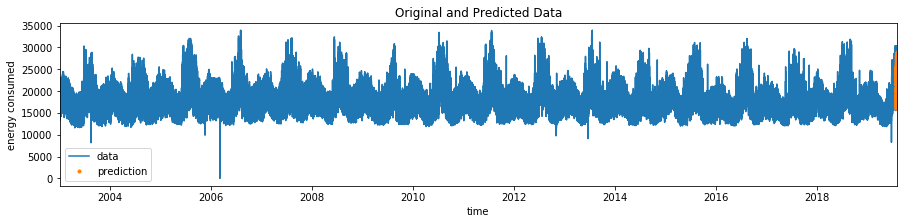

In [43]:
plot_(df, df['Load'], df.index[0].date(), df.index[-1].date(), 'Original and Predicted Data')

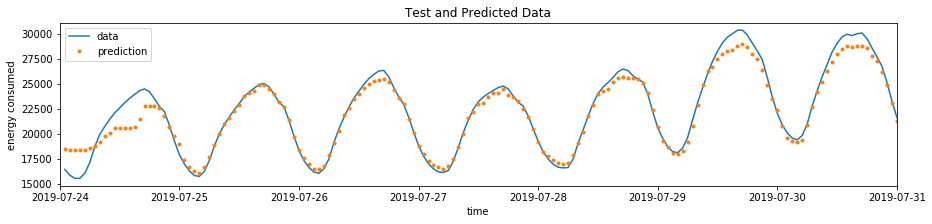

In [44]:
plot_(X_test, y_test, y_test.index[0].date(), y_test.index[-1].date(), 'Test and Predicted Data')

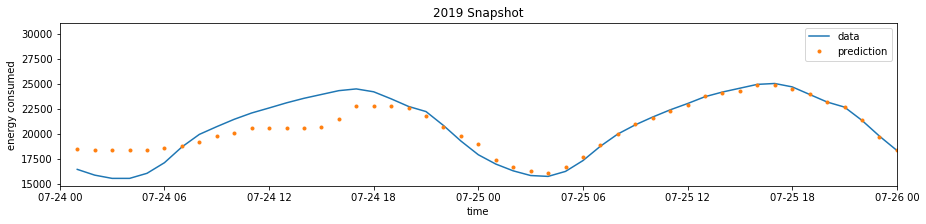

In [46]:
plot_(X_test, y_test, '07-24-2019', '07-26-2019', '2019 Snapshot')


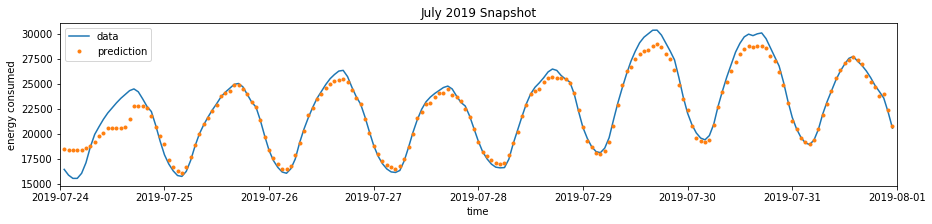

In [47]:
plot_(X_test, y_test, '07-24-2019', '08-01-2019', 'July 2019 Snapshot')


In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from numba import jit
import math

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [49]:
def forecast_error(y_true, y_pred):
    return y_true - y_pred

In [50]:
def mean_forecast_error(forecast_error):
    return forecast_error.mean()

In [62]:
def smape(A, F):
    return (100/len(A)) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [63]:
def smape_fast(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = y_pred[i]
        c = a+b
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    out *= (200.0 / y_true.shape[0])
    return out

In [64]:
MSE = mean_squared_error(y_test, y_pred)
print(MSE)

664723.5599259859


In [65]:
MAE = mean_absolute_error(y_test, y_pred)
print(MAE)

517.1349055939459


In [66]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
print(MAPE)

2.347736822773445


In [67]:
sMAPE = smape(y_test, y_pred)
print(sMAPE)

2.347281905146162


In [68]:
RMSE = np.sqrt(MSE)
print(RMSE)

815.3058076120799


In [69]:
FE = forecast_error(y_test, y_pred)
MFE = mean_forecast_error(FE)
print(MFE)

213.36144172115806


In [70]:
r_squared = r2_score(y_test, y_pred)
print(r_squared)

0.9568994560662888


In [71]:
ev = explained_variance_score(y_test, y_pred)
print(ev)

0.9598511651635628


In [72]:
sMAPE_2 = smape_fast(y_test, y_pred)
print(sMAPE_2)

2.3472819051461618
